# Exploring Airbnb Data in Amsterdam

___
Data was collected from [InsideAirbnb](http://insideairbnb.com/) as of March 9th, 2023.

As stated on their 'about' page, "Inside Airbnb is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities". This data is openly provided, allowing the general public, local governments, advocacy groups, and more to examine the impact Airbnb has on their communities. 

This notebook was created to explore the data in Amsterdam, and to demonstrate some of the capabilities of python for spatial data analytics. 

In [1]:
# Import all neccessary libraries
import pandas as pd # Tabular data manipulation
import matplotlib.pyplot as plt # Graphics
import seaborn as sns # Graphics
import geopandas as gpd # Spatial data manipulation
import folium # Interactive Mapping
from wordcloud import WordCloud # Wordcloud Graphics
import contextily  # Background Tiles
from pysal.lib import weights  # Spatial weights
from pysal.explore import esda  # Exploratory Spatial analytics
from splot import esda as esdaplot # Exploratory spatial data analysis

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/

## Non-Spatial Data Analysis

___

### Loading & Cleaning the Data

We begin by loading in the data and doing some cleanup. Notably, the data collected by Inside Airbnb categorizes the Airbnb listings by the "neighbourhood" they are in. However, what Inside Airbnb indicates as a neighbourhood can be better represented as a "borough". Renaming the data column is important as later on when we begin our spatial analysis, we will be further subdividing the listings by their actual "neighbourhoods". 

In [2]:
# Read in the listing data
listings_df = pd.read_csv("data/listings.csv")
listings_df.rename(columns={"neighbourhood": "borough"}, inplace=True) # Change "neighbourhood" to borough to better reflect data
listings_df.drop(columns=["neighbourhood_group", "minimum_nights", "number_of_reviews", 
                 "last_review", "reviews_per_month", "calculated_host_listings_count", 
                 "availability_365", "number_of_reviews_ltm"], inplace=True) # Remove unnecessary data columns.
listings_df.head()

,id,name,host_id,host_name,borough,latitude,longitude,room_type,price,license
0,2818,Quiet Garden View Room & Super Fast Wi-Fi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room,69,0363 5F3A 5684 6750 D14D
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,Centrum-Oost,52.36407,4.89393,Private room,106,0363 CBB3 2C10 0C2A 1E29
2,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.38761,4.89188,Private room,143,0363 974D 4986 7411 88D8
3,28871,Comfortable double room,124245,Edwin,Centrum-West,52.36775,4.89092,Private room,76,0363 607B EA74 0BD8 2F6F
4,29051,Comfortable single room,124245,Edwin,Centrum-Oost,52.36584,4.89111,Private room,56,0363 607B EA74 0BD8 2F6F


### Exploring the data

Using various seaborn/matplotlib plots (alongside pandas) to explore the data provided. 

For example, we can begin by seeing which hosts have the most listings in the area with a little bit of Python code:

In [20]:
# Count the number of times each host ID number appears, then remove extra data
host_id_counts = listings_df.value_counts("host_id").head(10) # Only check the top 10 hosts
list_sing_ids = listings_df.drop_duplicates('host_id')

print("TOP AMSTERDAM HOSTS BY LISTING COUNT\n")

# Iterate through the count data, and find the host names from amongst the reduced listings dataframe
for index, value in host_id_counts.items():
    host_name = list_sing_ids.loc[listings_df['host_id'] == index]["host_name"].item()
    print(f"Host: {host_name} | {value} listings.")

TOP AMSTERDAM HOSTS BY LISTING COUNT

Host: Sweets | 22 listings.
Host: Hotel Not Hotel | 20 listings.
Host: Arnold | 16 listings.
Host: Wittenberg | 14 listings.
Host: Abdullah | 14 listings.
Host: Remco | 12 listings.
Host: ClinkNOORD | 12 listings.
Host: Bunk | 12 listings.
Host: Neal Estate | 10 listings.
Host: Henk | 10 listings.


___
It wouldn't make sense to compare the cost of private rooms vs entire houses, so we can create subsets of our data, such as listings that are private rooms, to get further insights. 

One way of understanding the prices of the listings per borough is by creating a boxplot. As we can see below, although most listings fall within certain ranges, there are multiple (very expensive) outliers. I am attempted to manually check these private rooms to understand why they cost so far above the average, but for now that is outside the scope of this exploration.

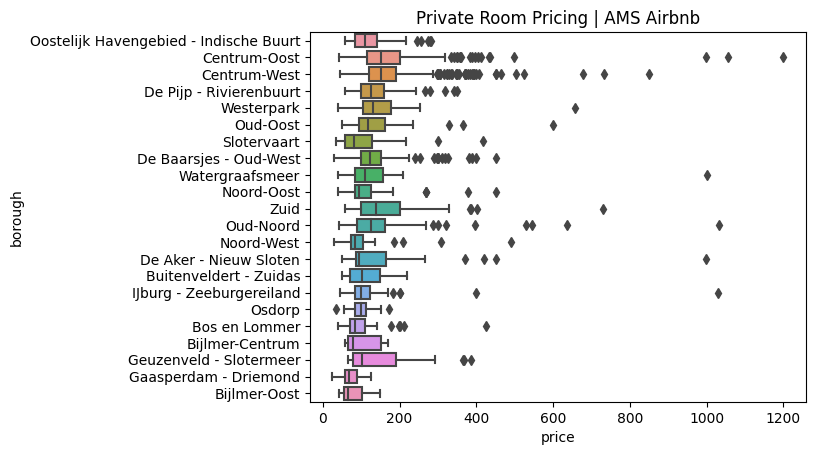

In [8]:
subset = listings_df.loc[listings_df['room_type'].isin(["Private room"])]
sns.boxplot(x='price', y='borough', data=subset).set_title("Private Room Pricing | AMS Airbnb")
plt.show()

___
Plotting according to borough (as seen below) allows us to see the listings, alongside the outlines of the borough. Later on we'll be using a neighbourhood geojson file to conduct spatial analysis.

[]

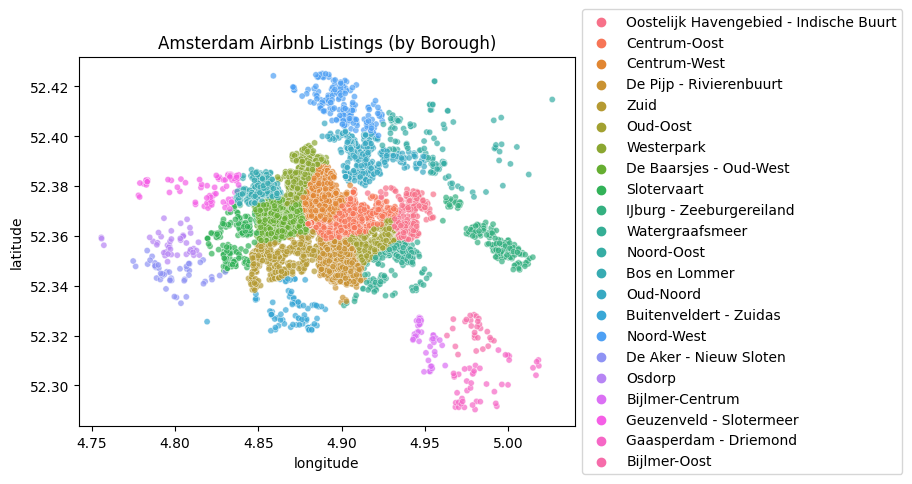

In [23]:
borough_scatter = sns.scatterplot(x='longitude', y='latitude', hue='borough', 
                          alpha=0.7, s=20, data=listings_df)
borough_scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
borough_scatter.set_title("Amsterdam Airbnb Listings (by Borough)")
scatter.plot()

___
From the previous plot, it is evident there are far too many listings/points overlapping for us to clearly see what is happening. To see the density of listings and find spatial patterns, we can use seaborns kdeplot (kernel density plot). From the seaborn documentation, "a kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset". 

To get a better sense (context) of the area, I have included an image of a map of Amsterdam for the background. Later on, we will be using a different tool for setting the basemap of the plots. This demonstrates the variaty of ways we can display spatial data and its surrounding context.

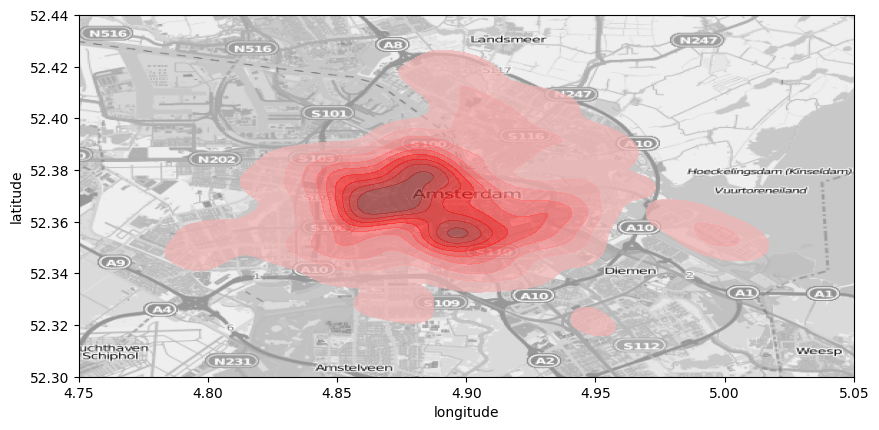

In [26]:
plt.figure(figsize=(10,8))

map_img = plt.imread("data/amsterdam.png") # Load image of Amsterdam

# Scale the image based on its lat/long to align it to the data
plt.imshow(map_img,zorder=0,extent=[4.699, 5.125, 52.247, 52.496]) 

# Create the kernel density estimate plot
sns.kdeplot(
    data=listings_df, x="longitude", y="latitude", fill=True, alpha=0.7, color="red"
)

plt.axis([4.75, 5.05, 52.30, 52.44])
plt.show()

<Figure size 1000x800 with 0 Axes>

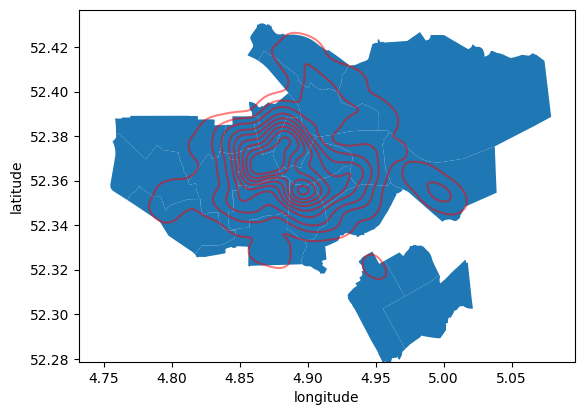

In [25]:
plt.figure(figsize=(10,8))


boroughs_gdf = gpd.read_file('data/boroughs.geojson') # WGS84 Latitude/Longitude
boroughs_gdf.rename(columns={"neighbourhood": "borough"}, inplace=True)
boroughs_gdf.plot()


sns.kdeplot(
    data=listings_df, x="longitude", y="latitude", fill=False, alpha=0.5, color="red"
)

# plt.axis([4.75, 5.05, 52.30, 52.44])
plt.show()

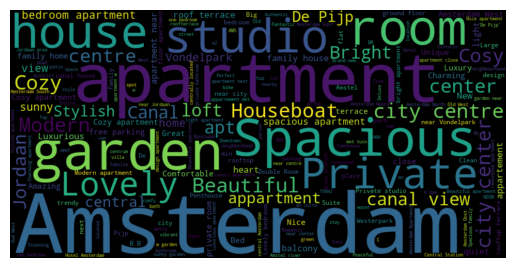

In [7]:
# We can even create a beautiful looking wordcloud from the names of the Airbnb Listings
# Although we can't extract much useful information from this plot, it is still aesthetically pleasing
# and funny to see all the different ways people are spelling "apartment" :P

text = ""
for name in listings_df['name']: # Collect all listing names into single string
    text += " " + name

# Create the wordcloud object
wordcloud = WordCloud(width=960, height=480).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

<Axes: >

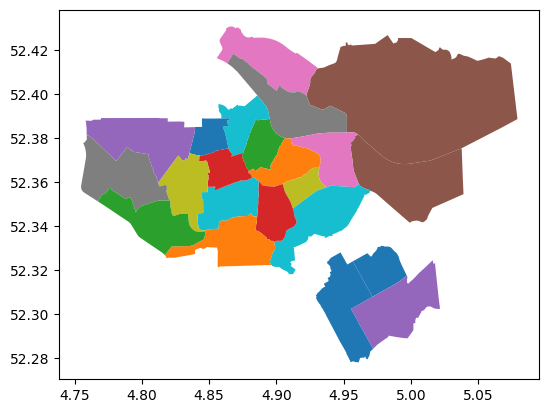

In [9]:
listings_gdf = gpd.GeoDataFrame(
    listings_df, geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude), crs="EPSG:4231" 
).to_crs(epsg=28992)

boroughs_gdf.plot(column = "borough")

In [10]:
# join_left_df = gpd.sjoin(listings_gdf, neighbourhoods_gdf, how="inner", predicate="within")
# join_left_df.head()
grouped = listings_gdf.groupby('borough').mean()
merged = pd.merge(boroughs_gdf, grouped, on="borough")

data_map = folium.Map(location=[52.377956, 4.897070], zoom_start=11)
folium.GeoJson(merged, name="geojson",
                tooltip=folium.features.GeoJsonTooltip(
                    fields=['borough', 'price'],
                    aliases=['Borough name:', 'Average price'],
                )
              ).add_to(data_map)
data_map
# folium.GeoJson(listings_gdf, name="geojson",
#                 tooltip=folium.features.GeoJsonTooltip(
#                     fields=['neighbourhood'],
#                     aliases=['Neighbourhood name:'],
#                 )
#               ).add_to(data_map)

/var/folders/ky/nl9r2_y11n13lb7wdfnhzby80000gn/T/ipykernel_8147/1237251825.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = listings_gdf.groupby('borough').mean()


In [11]:
neighbourhoods_gdf = gpd.read_file('data/neighbourhoods.geojson').to_crs(epsg=28992) # WGS84 Latitude/Longitude

# listings_gdf = gpd.GeoDataFrame(
#     listings_df, geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude), crs="EPSG:4326" 
# )

# neighbourhoods_gdf.plot(column = "name")

join_left_df = listings_gdf.sjoin(neighbourhoods_gdf, how="left", predicate="within")
join_left_df

,id,name_left,host_id,host_name,borough,latitude,longitude,room_type,price,license,geometry,index_right,name_right
0,2818,Quiet Garden View Room & Super Fast Wi-Fi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.364350,4.943580,Private room,69,0363 5F3A 5684 6750 D14D,POINT (124693.888 486280.202),66.0,Indische Buurt Oost
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,Centrum-Oost,52.364070,4.893930,Private room,106,0363 CBB3 2C10 0C2A 1E29,POINT (121311.767 486270.906),3.0,Grachtengordel-Zuid
2,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.387610,4.891880,Private room,143,0363 974D 4986 7411 88D8,POINT (121190.032 488891.072),5.0,Haarlemmerbuurt
3,28871,Comfortable double room,124245,Edwin,Centrum-West,52.367750,4.890920,Private room,76,0363 607B EA74 0BD8 2F6F,POINT (121109.543 486681.765),1.0,Burgwallen-Nieuwe Zijde
4,29051,Comfortable single room,124245,Edwin,Centrum-Oost,52.365840,4.891110,Private room,56,0363 607B EA74 0BD8 2F6F,POINT (121121.029 486469.158),3.0,Grachtengordel-Zuid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6993,842462220391708128,Flat in the center of Amsterdam,47205615,Edgar,Centrum-Oost,52.359386,4.893717,Entire home/apt,450,0363 80A2 E913 8FAD A98A,POINT (121293.730 485749.888),7.0,De Weteringschans
6994,842493348876281257,3bed ark close to city centre,454835217,Barbara,Oud-Noord,52.401950,4.902256,Entire home/apt,360,0363 B755 6BD8 6F8D AA7F,POINT (121907.092 490481.894),87.0,Buiksloterham
6995,842634905680862660,ground floor studio 46m2 at boulevard & canal,504448710,Ivanka,Oud-Noord,52.393502,4.899826,Entire home/apt,92,0363 76A0 B46B 281A C38E,POINT (121735.419 489542.999),87.0,Buiksloterham
6996,842713539293550316,Oasis in trendy Amsterdam East,17537276,Thomas,Watergraafsmeer,52.351350,4.920430,Entire home/apt,250,0363 97C2 71FF 5383 DC95,POINT (123107.715 484843.654),71.0,Frankendael


In [12]:
grouped_neighbourhood_lst = join_left_df.groupby('name_right').mean()
nei_merged = pd.merge(neighbourhoods_gdf, grouped_neighbourhood_lst, left_on="name", right_on="name_right")

/var/folders/ky/nl9r2_y11n13lb7wdfnhzby80000gn/T/ipykernel_8147/672909152.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_neighbourhood_lst = join_left_df.groupby('name_right').mean()


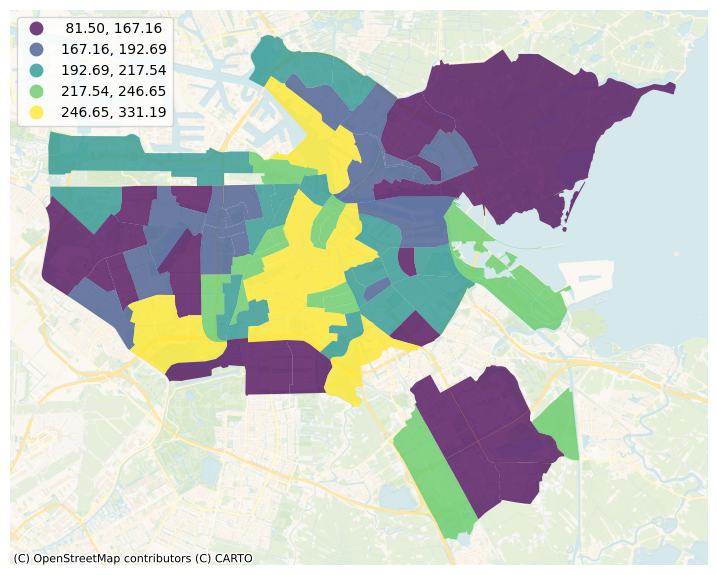

In [13]:
#Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
nei_merged.plot(
    column="price",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=nei_merged.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [14]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(nei_merged, k=3)
# Row-standardization
w.transform = "R"

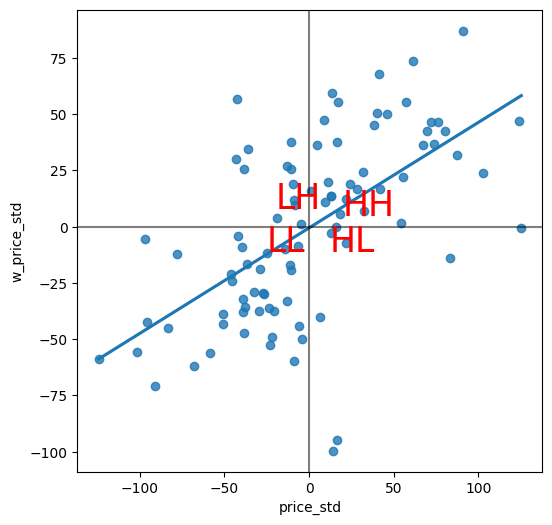

In [15]:
nei_merged["w_price"] = weights.lag_spatial(w, nei_merged['price'])

nei_merged["price_std"] = nei_merged["price"] - nei_merged["price"].mean()
nei_merged["w_price_std"] = weights.lag_spatial(w, nei_merged['price_std'])


# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="price_std", y="w_price_std", data=nei_merged, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()

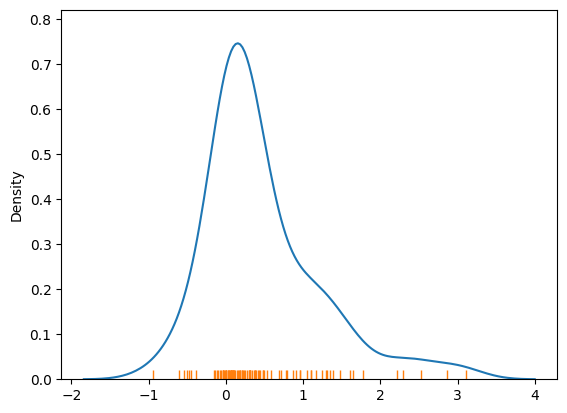

In [16]:
lisa = esda.moran.Moran_Local(nei_merged["price"], w)

# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

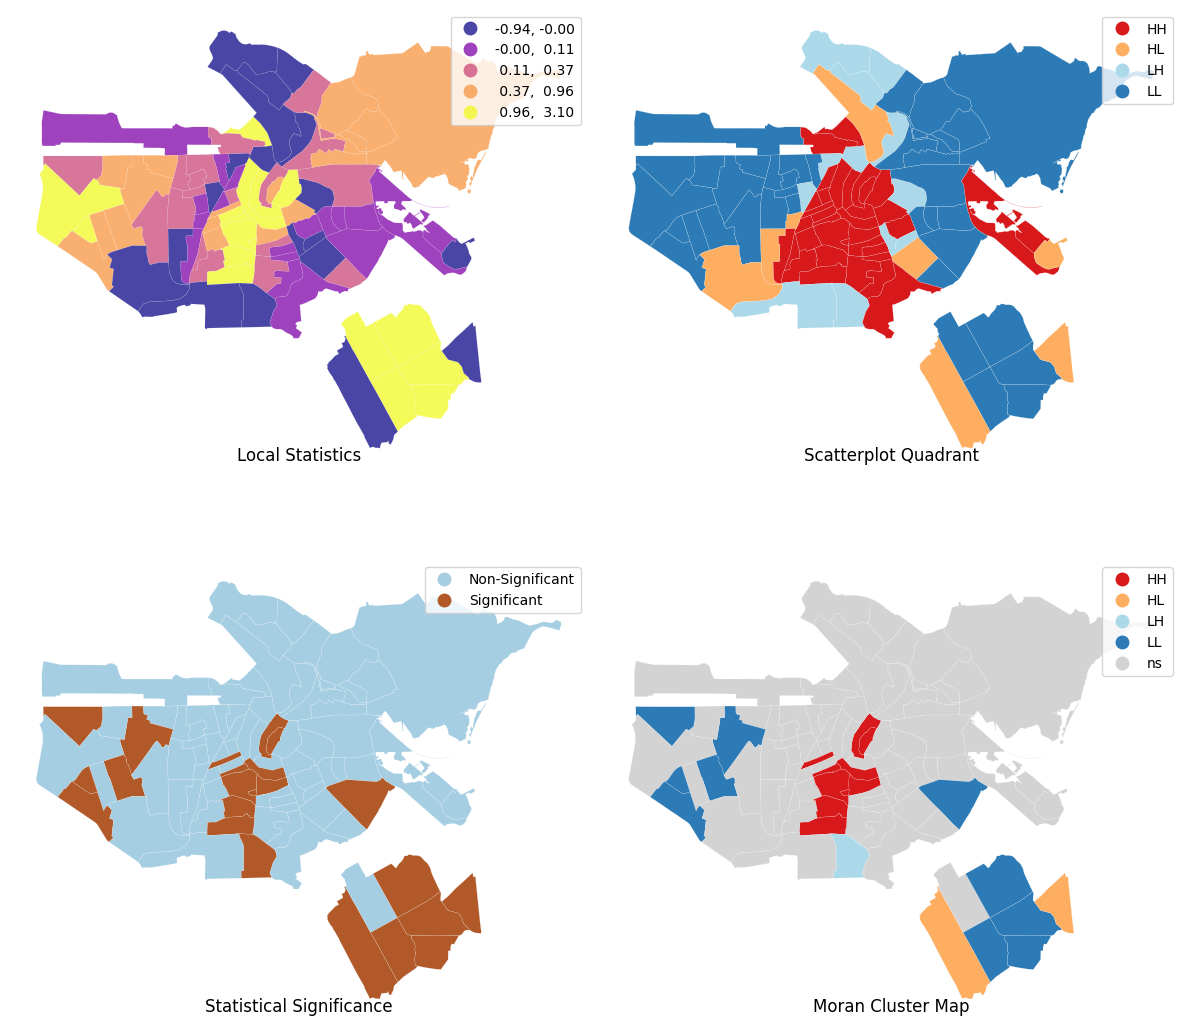

In [17]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
nei_merged.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, nei_merged, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=nei_merged.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
nei_merged.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, nei_merged, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [18]:
# Assign pseudo P-values to `db`
nei_merged["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
nei_merged["sig"] = sig


# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
nei_merged["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=nei_merged.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)

# Print top of the table to inspect
nei_merged.loc[nei_merged['sig'] == 1][["name", "labels", "p-sim"]]

,name,labels,p-sim
0,Burgwallen-Oude Zijde,HH,0.043
1,Burgwallen-Nieuwe Zijde,HH,0.022
7,De Weteringschans,HH,0.010
18,Van Lennepbuurt,HH,0.027
21,Vondelbuurt,HH,0.023
30,Slotermeer-Zuidwest,LL,0.034
32,Eendracht,LL,0.017
34,Osdorp-Oost,LL,0.028
36,De Punt,LL,0.010
37,Middelveldsche Akerpolder en Sloten,LL,0.044
